## Dataset Description
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Reservation Cancellation Prediction dataset.
Feature distributions are close to, but not exactly the same, as the original.
Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

## Files:
- train.csv - the training dataset; booking_status is the target (e.g., whether the reservation was cancelled)
- test.csv - the test dataset; your objective is to predict booking_status
- sample_submission.csv - a sample submission file in the correct format

### Evaluation:
- Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

#### Here is a brief explanation of each column in the train.csv dataset (based on the context and typical meanings):
- id: Unique identifier for each reservation.
- no_of_adults: Number of adults included in the reservation.
- no_of_children: Number of children included in the reservation.
- no_of_weekend_nights: Number of weekend nights (Friday/Saturday) stayed.
- no_of_week_nights: Number of week nights (Sunday-Thursday) stayed.
- type_of_meal_plan: Categorical code for the meal plan selected (e.g., 0, 1, 2, 3).
- required_car_parking_space: Indicates if a car parking space was required (0 = No, 1 = Yes).
- room_type_reserved: Categorical code for the reserved room type (e.g., 0-6).
- lead_time: Number of days between booking and arrival.
- arrival_year: Year of arrival.
- arrival_month: Month of arrival.
- arrival_date: Day of arrival.
- market_segment_type: Categorical code for market segment (e.g., 0-4).
- repeated_guest: Indicates if the guest is a repeat guest (0 = No, 1 = Yes).
- no_of_previous_cancellations: Number of previous cancellations by the guest.
- no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the guest.
- avg_price_per_room: Average price per room for the reservation.
- special_requests: Number of special requests made by the guest.
- booking_status: Target variable; 1 means reservation was cancelled, 0 means not cancelled.

### Submission File:
- For each id in the test set, you must predict the value for the target booking_status. The file should contain a header and have the following format:


| id    | booking_status |
|-------|----------------|
| id    | booking_status |
| 42100 | 0              |
| 42101 | 1              |
| 42102 | 0              |

#### Private Score -> 0.8130
#### Public Score -> 0.81776
#### Leaderboard Rank -> 543/678 top 80%

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from Kaggle.Challenges.utils import get_stats

# let's import Fast classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

# let's import some Average classifiers
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# let's import some Heavy classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC as KernelSVM

# let's use RFE to select most usefully features
from sklearn.feature_selection import RFE, RFECV

In [2]:
test_data_path = './data/cancellation/test.csv'
train_data_path = './data/cancellation/train.csv'
sample_submission_path = './data/cancellation/sample_submission.csv'
target_columns = 'booking_status'

In [3]:
test_df = pd.read_csv(test_data_path)
train_df = pd.read_csv(train_data_path)
test_ids = test_df['id']
sample_submission_df = pd.read_csv(sample_submission_path)

In [123]:
train_df.head(5)

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [124]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    42100 non-null  int64  
 1   no_of_adults                          42100 non-null  int64  
 2   no_of_children                        42100 non-null  int64  
 3   no_of_weekend_nights                  42100 non-null  int64  
 4   no_of_week_nights                     42100 non-null  int64  
 5   type_of_meal_plan                     42100 non-null  int64  
 6   required_car_parking_space            42100 non-null  int64  
 7   room_type_reserved                    42100 non-null  int64  
 8   lead_time                             42100 non-null  int64  
 9   arrival_year                          42100 non-null  int64  
 10  arrival_month                         42100 non-null  int64  
 11  arrival_date   

In [125]:
train_df.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000
mean,21049.500000,1.920713,0.141093,0.884632,2.398005,0.239192,0.025249,0.428931,103.888029,2017.856295,7.593539,15.902945,0.728504,0.029192,0.019715,0.175772,104.566377,0.571734,0.392019
std,12153.367503,0.524950,0.450128,0.885693,1.427330,0.587674,0.156884,0.832605,81.069343,0.350795,2.829395,8.888582,0.633529,0.168347,0.325837,1.732121,37.139165,0.775041,0.488207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10524.750000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000
50%,21049.500000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,93.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,31574.250000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,155.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000,1.000000
max,42099.000000,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


In [126]:
# let's investigate data
# no_of_adults have min 0, max 4 - Ok!
# no_of_children have min 0, max 9 ( need to check outliers) -> only two rows have 9 children, we can drop these rows
# train_df = train_df[train_df['no_of_children'] < 9]
# test_df = test_df[test_df['no_of_children'] < 9]

# no_of_weekend_nights have min 0, max 7 - Ok!
# no_of_week_nights have min 0, max 17 - Ok!
# type_of_meal_plan have 4 unique values (0, 1, 2, 3) - Ok!
# required_car_parking_space have 2 unique values (0, 1) - Ok!
# room_type_reserved have 7 unique values (0, 1, 2, 3, 4, 5, 6) - Ok!
# lead_time have min 0, max 443 - Ok!
# arrival_year - todo: check if we have data for multiple years ?
# arrival_month - todo: this can be used to create is_winter, is_summer, is_spring, is_fall features
# arrival_date - todo: check if this can be used to create any useful feature ?
# market_segment_type have 5 unique values (0, 1, 2, 3, 4) - Ok !
# repeated_guest have 2 unique values (0, 1) - Ok !
# no_of_previous_cancellations have min 0, max 13 - Ok !
# no_of_previous_bookings_not_canceled have min 0, max 58  - Ok !
# avg_price_per_room have min 0, max 540 - Ok !
# special_requests have min 0, max 5 - Ok !
# booking_status have 2 unique values (0, 1) - target variable (1 - means cancelled, 0 - means not cancelled)

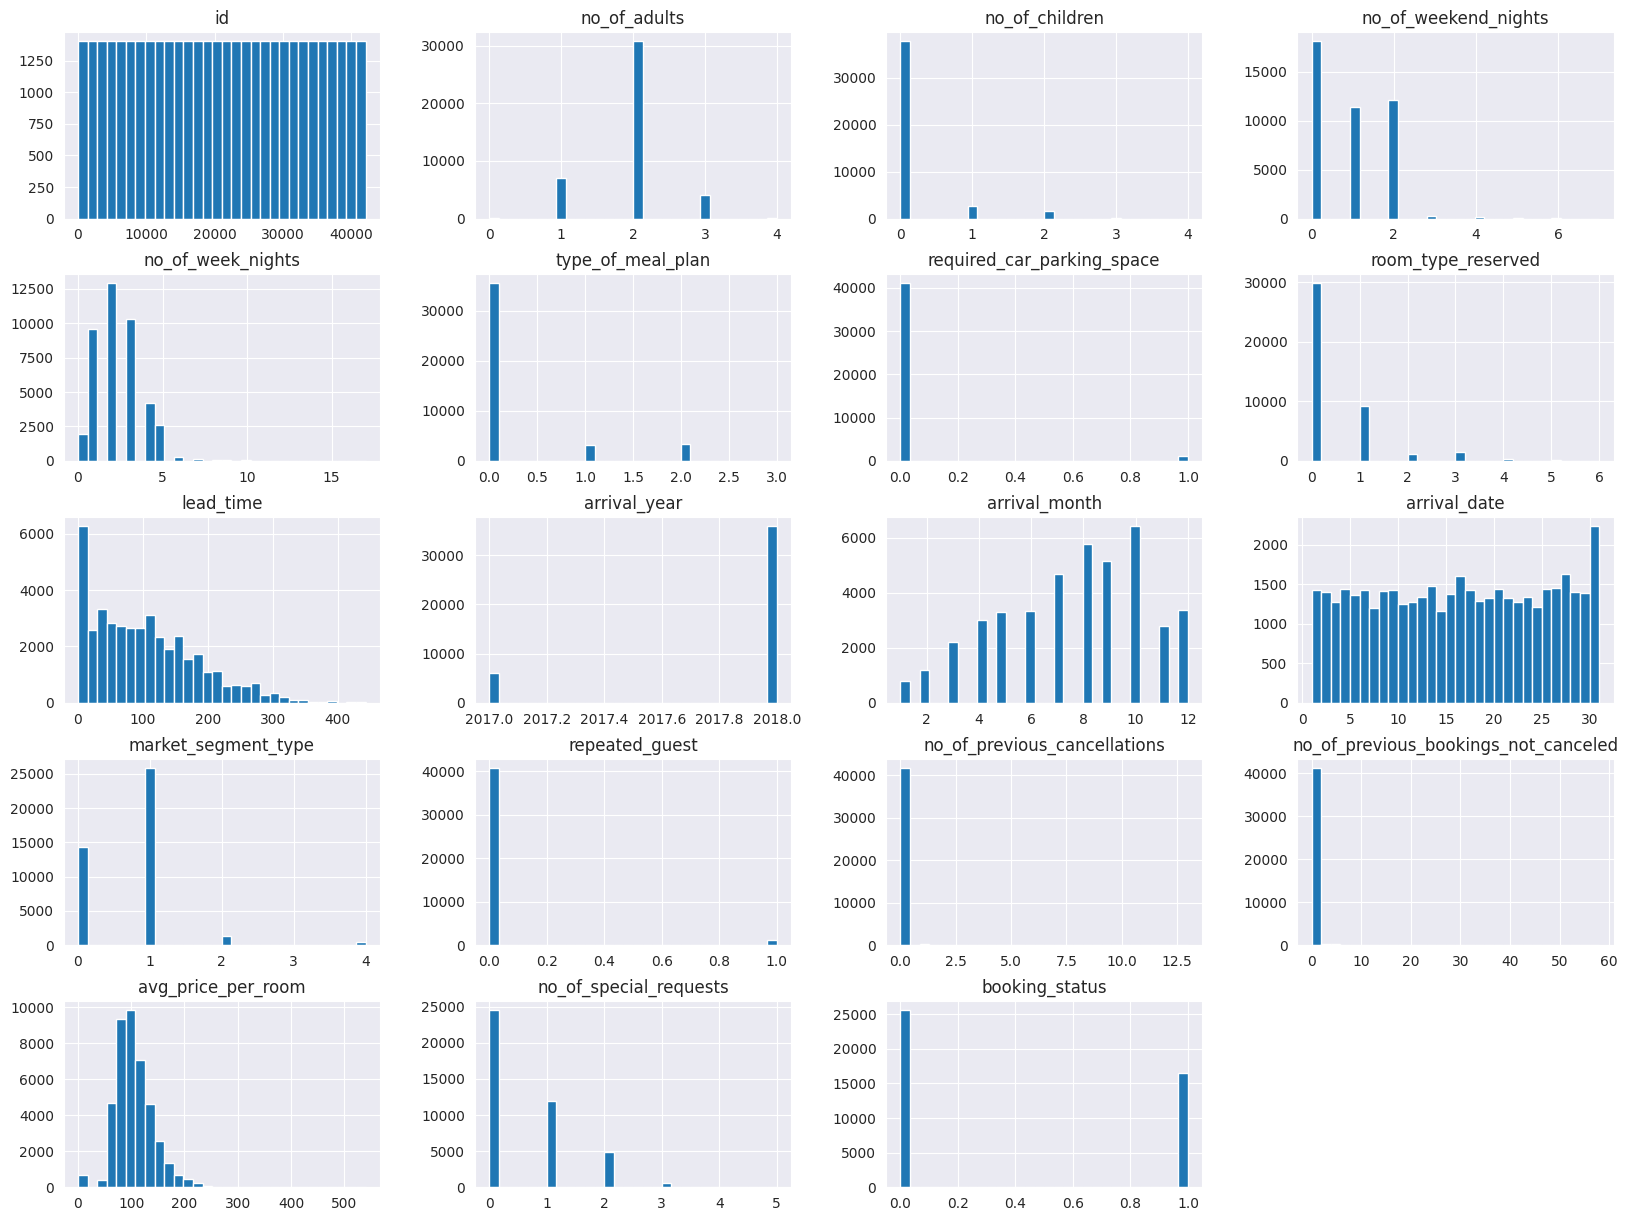

In [127]:
# let's plot some graphs to understand data better
train_df.hist(bins=30, figsize=(20,15))
plt.show()

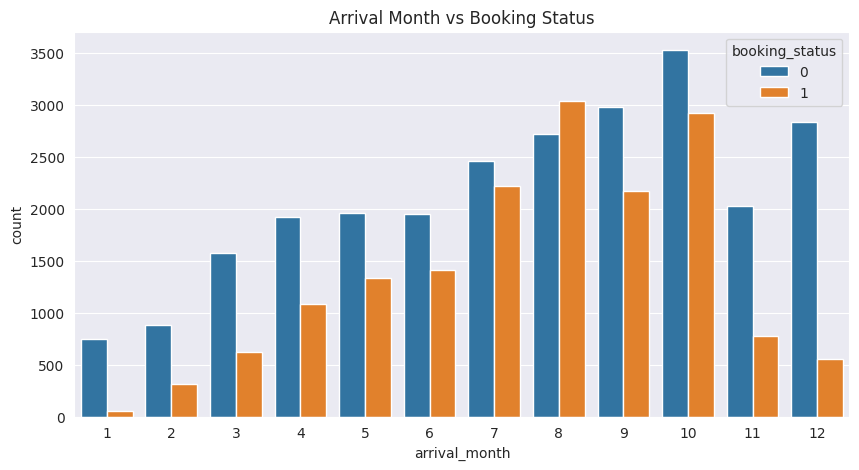

In [128]:
# let's check with arrival moths
plt.figure(figsize=(10,5))
sns.countplot(x='arrival_month', hue=target_columns, data=train_df)
plt.title('Arrival Month vs Booking Status')
plt.show()

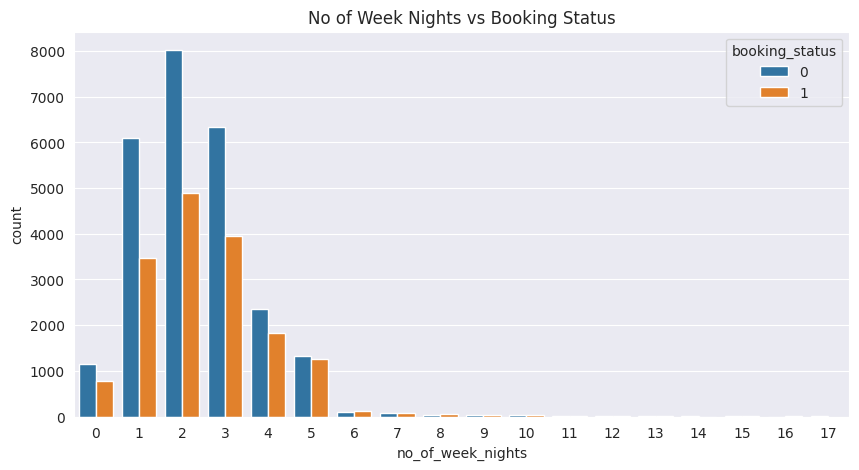

In [129]:
# let's check with no_of_weeks_nights
plt.figure(figsize=(10,5))
sns.countplot(x='no_of_week_nights', hue=target_columns, data=train_df)
plt.title('No of Week Nights vs Booking Status')
plt.show()

In [4]:
# seems we can can make new feature total_nights
train_df['total_nights'] = train_df['no_of_week_nights'] + train_df['no_of_weekend_nights']
test_df['total_nights'] = test_df['no_of_week_nights'] + test_df['no_of_weekend_nights']

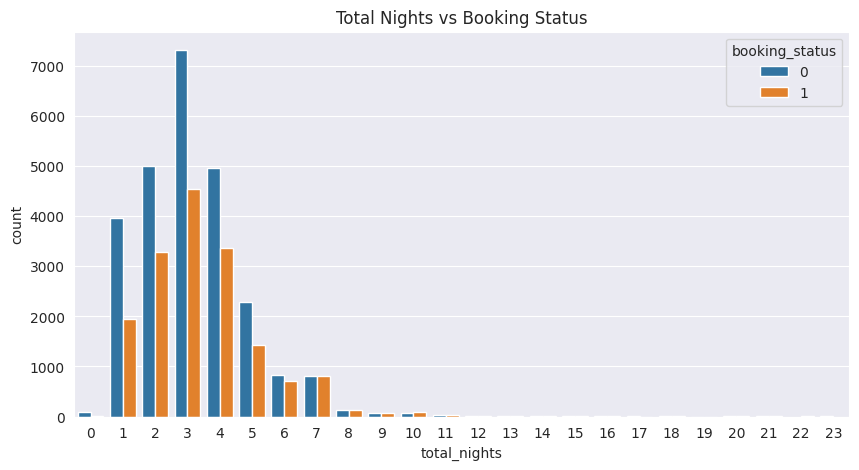

In [131]:
# let's check with total_nights
plt.figure(figsize=(10,5))
sns.countplot(x='total_nights', hue=target_columns, data=train_df)
plt.title('Total Nights vs Booking Status')
plt.show()

In [5]:
# we can try to cut total_nights into bins (0, 1-3, 4-7, 8-14, 15+)
train_df['total_nights_cutted'] = pd.cut(train_df['total_nights'], bins=[-1, 0, 3, 7, 14, 30], labels=[0, 1, 2, 3, 4])
test_df['total_nights_cutted'] = pd.cut(test_df['total_nights'], bins=[-1, 0, 3, 7, 14, 30], labels=[0, 1, 2, 3, 4])
# lets create a new feature for lead_time -> arriving_today (lead_time = 0)
train_df['arriving_today'] = train_df['lead_time'].apply(lambda x: 1 if x == 0 else 0)
test_df['arriving_today'] = test_df['lead_time'].apply(lambda x: 1 if x == 0 else 0)

# let's re-cut the lead_time_cutted, let's new bins 0 ( arriving today), 1-7 ( within a week), 8-30 ( within a month), 31-90 ( within 3 months), 91-180 ( within 6 months), 181+ ( more than 6 months)
train_df['lead_time_cutted'] = pd.cut(train_df['lead_time'], bins=[-1, 0, 7, 30, 90, 180, 500], labels=[0, 1, 2, 3, 4, 5])
test_df['lead_time_cutted'] = pd.cut(test_df['lead_time'], bins=[-1, 0, 7, 30, 90, 180, 500], labels=[0, 1, 2, 3, 4, 5])

# let's create a new feature for avg_price_per_room -> price_per_night
train_df['price_per_night'] = train_df.apply(lambda row: row['avg_price_per_room'] / row['total_nights'] if row['total_nights'] > 0 else row['avg_price_per_room'], axis=1)
test_df['price_per_night'] = test_df.apply(lambda row: row['avg_price_per_room'] / row['total_nights'] if row['total_nights'] > 0 else row['avg_price_per_room'], axis=1)

# we can cut price_per_night into bins (0-50, 51-200, 201+)
train_df['price_per_night_cutted'] = pd.cut(train_df['price_per_night'], bins=[-1, 50, 200, 6000], labels=[0, 1, 2])
test_df['price_per_night_cutted'] = pd.cut(test_df['price_per_night'], bins=[-1, 50, 200, 6000], labels=[0, 1, 2])

# let's create a new feature for special_requests -> has_special_requests ( special_requests > 0)
train_df['has_special_requests'] = train_df['no_of_special_requests'].apply(lambda x: 1 if x > 0 else 0)
test_df['has_special_requests'] = test_df['no_of_special_requests'].apply(lambda x: 1 if x > 0 else 0)

# let's create a new feature price per person -> price_per_person
train_df['total_people'] = train_df['no_of_adults'] + train_df['no_of_children']
test_df['total_people'] = test_df['no_of_adults'] + test_df['no_of_children']
train_df['price_per_person'] = train_df.apply(lambda row: row['avg_price_per_room'] / row['total_people'] if row['total_people'] > 0 else row['avg_price_per_room'], axis=1)
test_df['price_per_person'] = test_df.apply(lambda row: row['avg_price_per_room'] / row['total_people'] if row['total_people'] > 0 else row['avg_price_per_room'], axis=1)

# let's add some more features
# total_people_cutted (0, 1-2, 3-4, 5+)
train_df['total_people_cutted'] = pd.cut(train_df['total_people'], bins=[-1, 0, 2, 4, 10], labels=[0, 1, 2, 3])
test_df['total_people_cutted'] = pd.cut(test_df['total_people'], bins=[-1, 0, 2, 4, 10], labels=[0, 1, 2, 3])

# let's substract no_of_previous_cancellations from no_of_previous_bookings_not_canceled to create a new feature previous_bookings_total
train_df['previous_bookings_total'] = train_df['no_of_previous_cancellations'] + train_df['no_of_previous_bookings_not_canceled']
test_df['previous_bookings_total'] = test_df['no_of_previous_cancellations'] + test_df['no_of_previous_bookings_not_canceled']

# TODO: need to think about more features ...

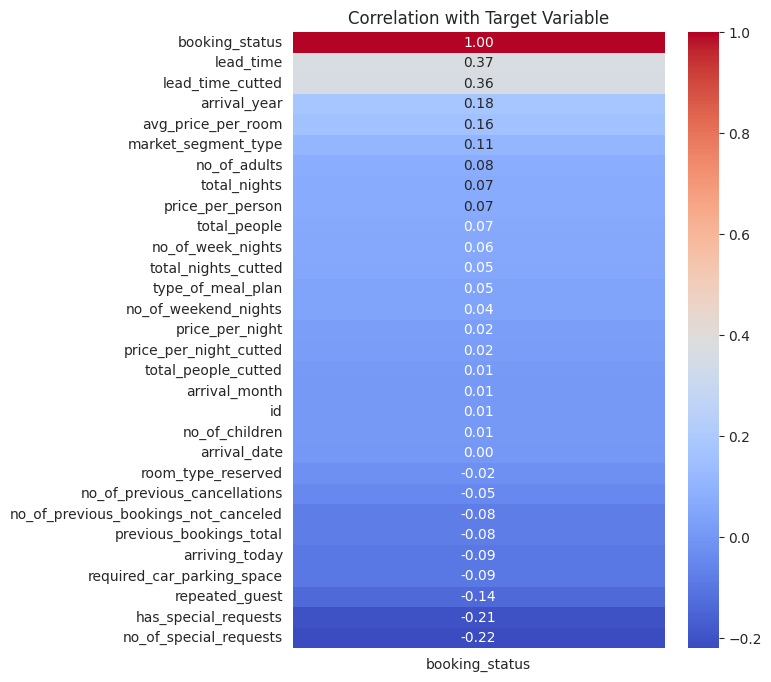

In [133]:
# let's check correlation with target variable only
correlation = train_df.corr()
correlation_target = correlation[[target_columns]].sort_values(by=target_columns, ascending=False)
plt.figure(figsize=(6,8))
sns.heatmap(correlation_target, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation with Target Variable')
plt.show()

In [6]:
# seems arrival_date, id, no_of_children, price_per_night, total_people_cutted have very low correlation with target variable
# let's drop these columns
# low_correlation_columns = ['arrival_date', 'id', 'no_of_children', 'price_per_night', 'total_people_cutted']
low_correlation_columns = ['id']

# copy ids for submission file
test_ids = test_df['id']

train_df = train_df.drop(columns=low_correlation_columns)
test_df = test_df.drop(columns=low_correlation_columns)

In [7]:
# split the data into train and validation
X = train_df.drop(columns=[target_columns])
y = train_df[target_columns]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [136]:
# let's try with RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


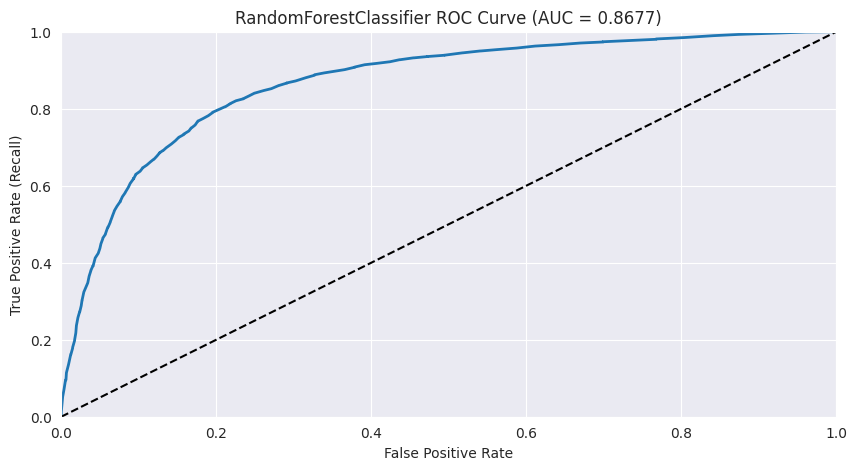

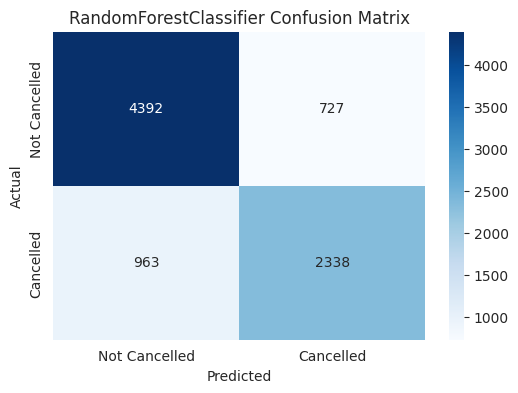

RandomForestClassifier Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      5119
           1       0.76      0.71      0.73      3301

    accuracy                           0.80      8420
   macro avg       0.79      0.78      0.79      8420
weighted avg       0.80      0.80      0.80      8420

RandomForestClassifier Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     20475
           1       0.76      0.71      0.74     13203

    accuracy                           0.80     33678
   macro avg       0.79      0.79      0.79     33678
weighted avg       0.80      0.80      0.80     33678



In [137]:
# let's check stats for RandomForestClassifier
get_stats(rfc_model, X_val, y_val, X_train, y_train)

In [138]:
# predict on validation set
y_val_pred = rfc_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f'Validation ROC AUC: {roc_auc:.4f}')

Validation ROC AUC: 0.8717


In [8]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42, )

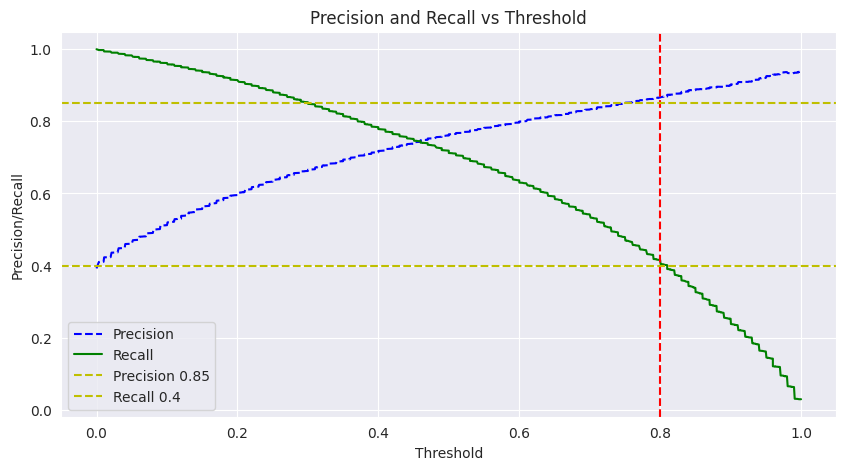

In [139]:
y_cross_train_predicted = cross_val_predict(rfc_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_cross_train_predicted)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.axvline(x=0.8, color='r', linestyle='--')
    plt.axhline(y=0.85, color='y', linestyle='--', label='Precision 0.85')
    plt.axhline(y=0.4, color='y', linestyle='--', label='Recall 0.4')
    plt.xlabel("Threshold")
    plt.ylabel("Precision/Recall")
    plt.title("Precision and Recall vs Threshold")
    plt.legend()
    plt.grid(visible=True)
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [9]:
# try to scale and re-train again
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# let's re-create a DataFrames with column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# let's fill nan using imputer
imputer = KNNImputer(n_neighbors=2)  # you can change n_neighbors

# Convert back to DataFrame (optional)
X_train_scaled = pd.DataFrame(imputer.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
X_val_scaled = pd.DataFrame(imputer.fit_transform(X_val_scaled), columns=X_val_scaled.columns)

Training GaussianNB...
Stats for GaussianNB:


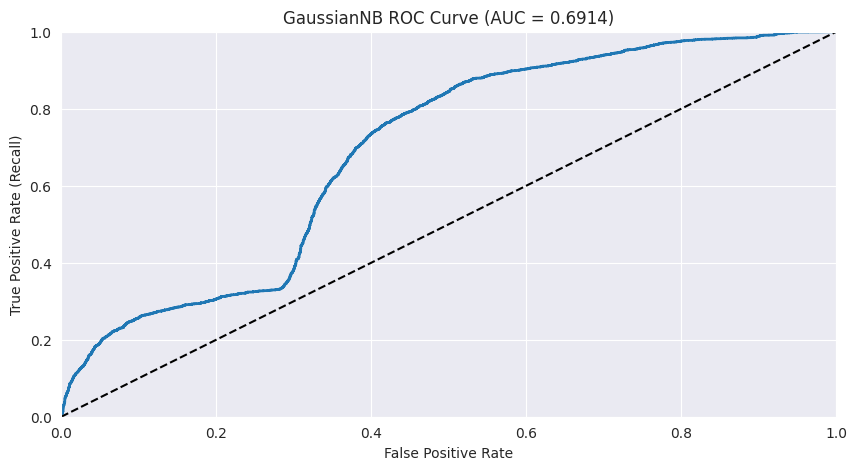

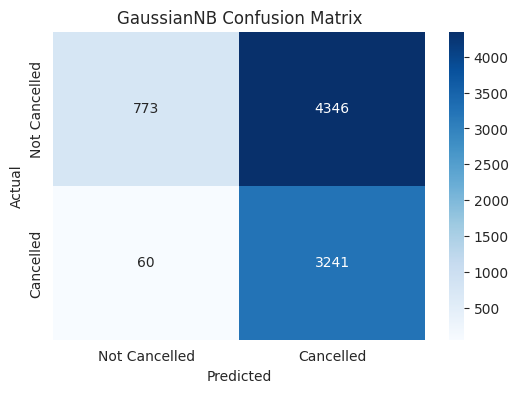

GaussianNB Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.15      0.26      5119
           1       0.43      0.98      0.60      3301

    accuracy                           0.48      8420
   macro avg       0.68      0.57      0.43      8420
weighted avg       0.73      0.48      0.39      8420

GaussianNB Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.11      0.19     20475
           1       0.42      0.99      0.59     13203

    accuracy                           0.45     33678
   macro avg       0.68      0.55      0.39     33678
weighted avg       0.73      0.45      0.35     33678



Training LogisticRegression...
Stats for LogisticRegression:


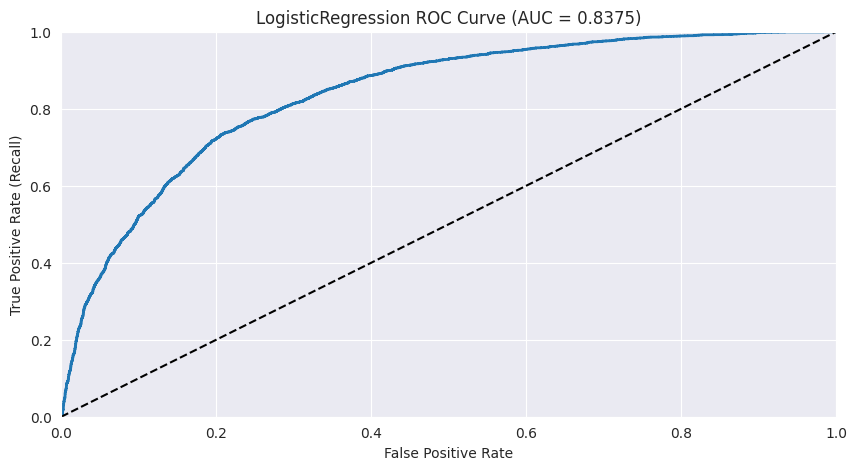

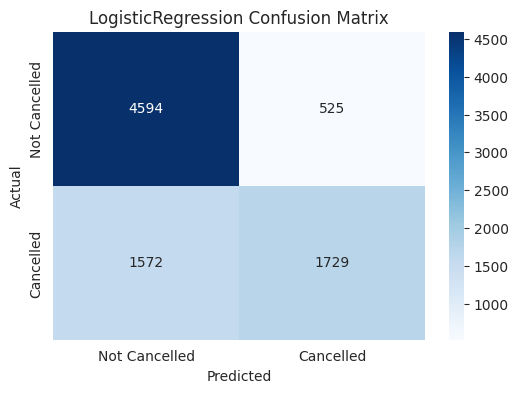

LogisticRegression Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.81      5119
           1       0.77      0.52      0.62      3301

    accuracy                           0.75      8420
   macro avg       0.76      0.71      0.72      8420
weighted avg       0.75      0.75      0.74      8420

LogisticRegression Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.82     20475
           1       0.77      0.52      0.62     13203

    accuracy                           0.75     33678
   macro avg       0.76      0.71      0.72     33678
weighted avg       0.76      0.75      0.74     33678



Training SGDClassifier...
Stats for SGDClassifier:


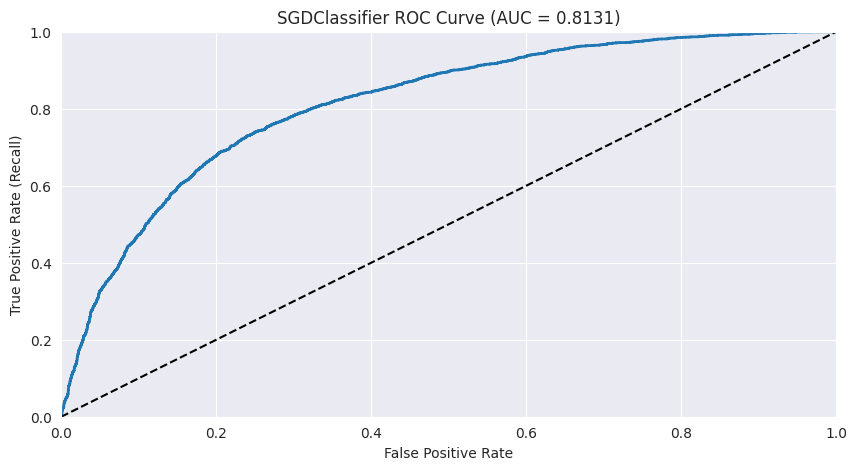

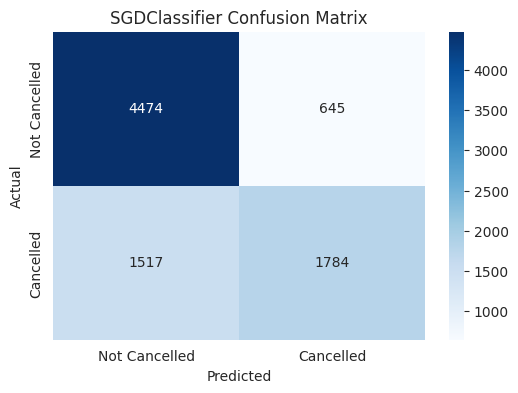

SGDClassifier Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81      5119
           1       0.73      0.54      0.62      3301

    accuracy                           0.74      8420
   macro avg       0.74      0.71      0.71      8420
weighted avg       0.74      0.74      0.73      8420

SGDClassifier Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81     20475
           1       0.77      0.52      0.62     13203

    accuracy                           0.75     33678
   macro avg       0.76      0.71      0.72     33678
weighted avg       0.75      0.75      0.74     33678





In [141]:
# let's iterate training for fast classifiers
fast_classifiers = {
    "GaussianNB": GaussianNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SGDClassifier": SGDClassifier(random_state=42)
}

for name, model in fast_classifiers.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    print(f"Stats for {name}:")
    get_stats(model, X_val_scaled, y_val, X_train_scaled, y_train)
    print("\n")

In [57]:
# let's use RFE and RFECV for LogisticRegression and RandomSearchGrid
max_num_features = len(X.columns)
step = 2
# Best Params:
# Score 0.83694

param_grid = {
        "n_features_to_select": [20, 21, 22, 23, 24, 25, 26, 27, 28],
    }


model = LogisticRegression(random_state=42, solver='saga', penalty='elasticnet', l1_ratio=1, max_iter=1350, C=22) # create model with default params

rfe_estimator = RFE(model)
random_search = RandomizedSearchCV(
    rfe_estimator,
    param_grid,
    cv=cv,
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    return_train_score=False,
    scoring='roc_auc',
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits


,estimator,RFE(estimator...olver='saga'))
,param_distributions,"{'n_features_to_select': [20, 21, ...]}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [58]:
best_model = random_search.best_estimator_
best_score = random_search.best_score_
best_params = random_search.best_params_

In [59]:
print(f'Best Score : {best_score}')
print('\n')
print(f'Best Params: {best_params}')

Best Score : 0.8369438951847886


Best Params: {'n_features_to_select': 28}


In [11]:
model = LogisticRegression(random_state=42,
                           solver='saga',
                           penalty='elasticnet',
                           l1_ratio=1,
                           max_iter=1350,
                           C=22)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',
    min_features_to_select=5
)

rfecv.fit(X_train_scaled, y_train)

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", rfecv.support_)

/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Optimal number of features: 28
Selected features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [13]:
rfecv_test_score = rfecv.score(X_val_scaled, y_val)
rfecv_test_score

0.8381876087085557

In [14]:
rfecv_train_score = rfecv.score(X_train_scaled, y_train)
rfecv_train_score

0.8376711141021103

/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

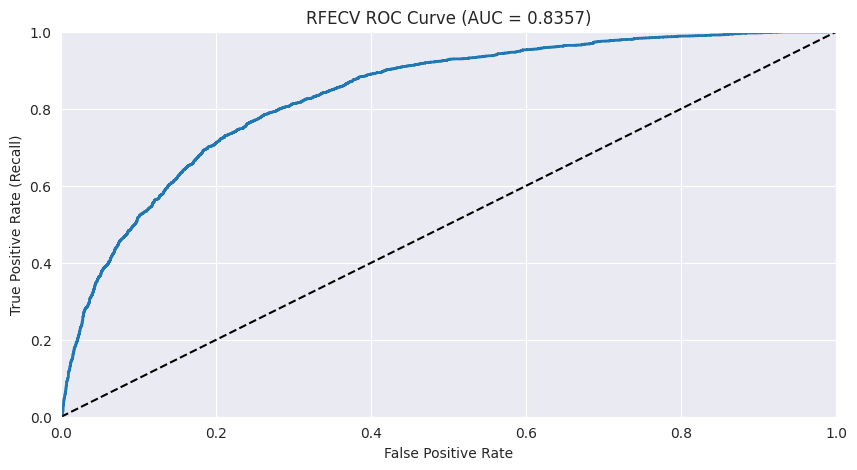

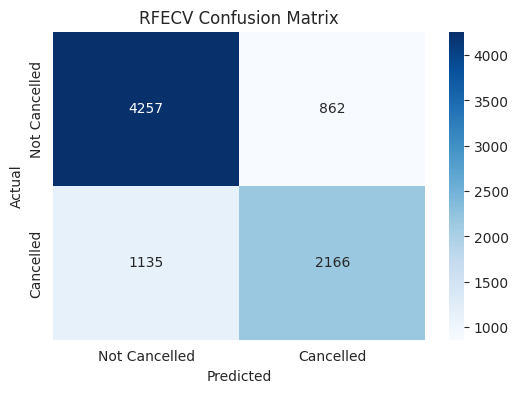

RFECV Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      5119
           1       0.72      0.66      0.68      3301

    accuracy                           0.76      8420
   macro avg       0.75      0.74      0.75      8420
weighted avg       0.76      0.76      0.76      8420

RFECV Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82     20477
           1       0.73      0.66      0.69     13203

    accuracy                           0.77     33680
   macro avg       0.76      0.75      0.75     33680
weighted avg       0.77      0.77      0.77     33680



In [15]:
get_stats(rfecv, X_val_scaled, y_val, X_train_scaled, y_train)

Training GradientBoostingClassifier...
Stats for GradientBoostingClassifier:


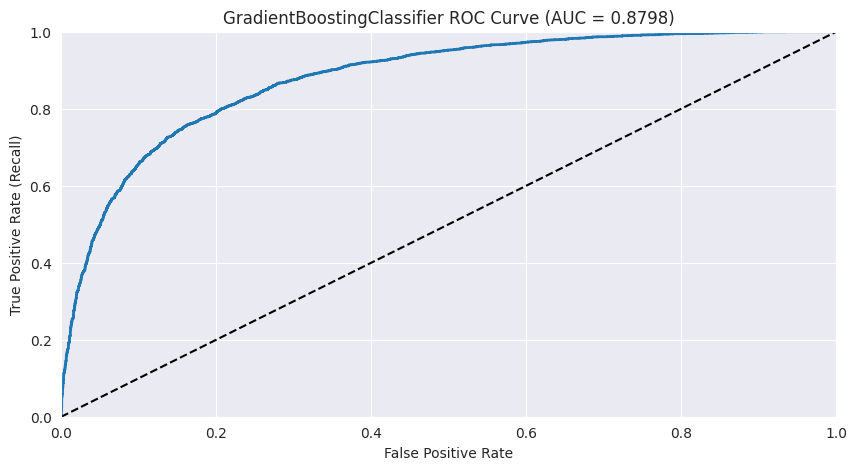

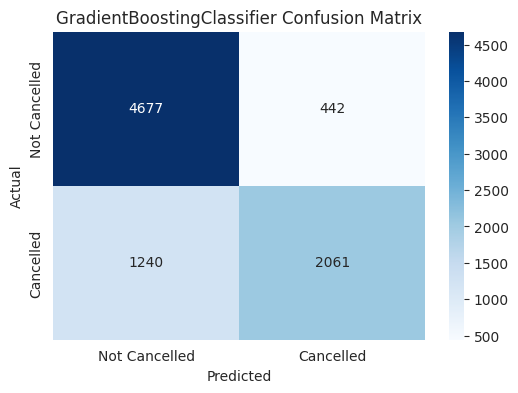

GradientBoostingClassifier Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      5119
           1       0.82      0.62      0.71      3301

    accuracy                           0.80      8420
   macro avg       0.81      0.77      0.78      8420
weighted avg       0.80      0.80      0.79      8420

GradientBoostingClassifier Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85     20475
           1       0.82      0.63      0.71     13203

    accuracy                           0.80     33678
   macro avg       0.81      0.77      0.78     33678
weighted avg       0.80      0.80      0.80     33678



Training HistGradientBoostingClassifier...
Stats for HistGradientBoostingClassifier:


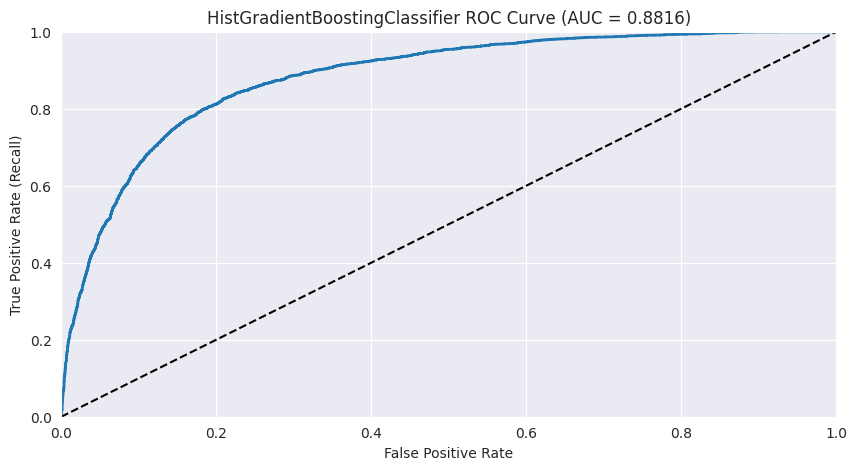

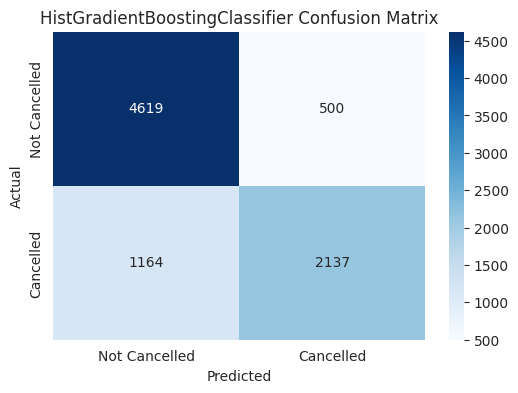

HistGradientBoostingClassifier Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      5119
           1       0.81      0.65      0.72      3301

    accuracy                           0.80      8420
   macro avg       0.80      0.77      0.78      8420
weighted avg       0.80      0.80      0.80      8420

HistGradientBoostingClassifier Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     20475
           1       0.82      0.66      0.73     13203

    accuracy                           0.81     33678
   macro avg       0.81      0.78      0.79     33678
weighted avg       0.81      0.81      0.80     33678



Training RandomForestClassifier...
Stats for RandomForestClassifier:


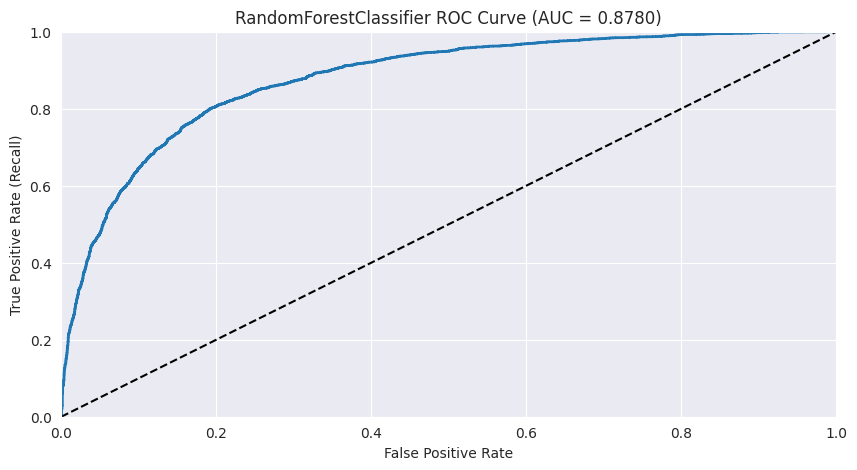

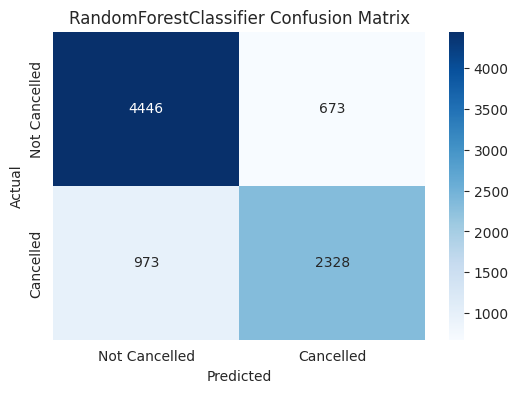

RandomForestClassifier Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      5119
           1       0.78      0.71      0.74      3301

    accuracy                           0.80      8420
   macro avg       0.80      0.79      0.79      8420
weighted avg       0.80      0.80      0.80      8420

RandomForestClassifier Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     20475
           1       0.79      0.71      0.75     13203

    accuracy                           0.81     33678
   macro avg       0.81      0.79      0.80     33678
weighted avg       0.81      0.81      0.81     33678



Training DecisionTreeClassifier...
Stats for DecisionTreeClassifier:


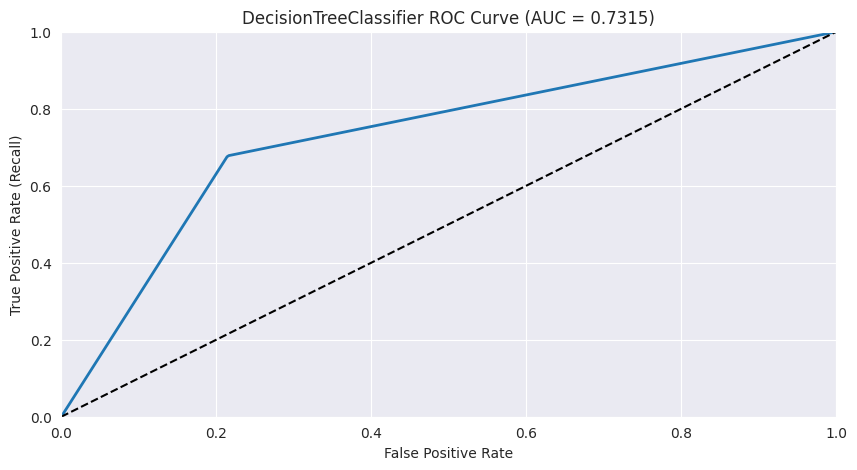

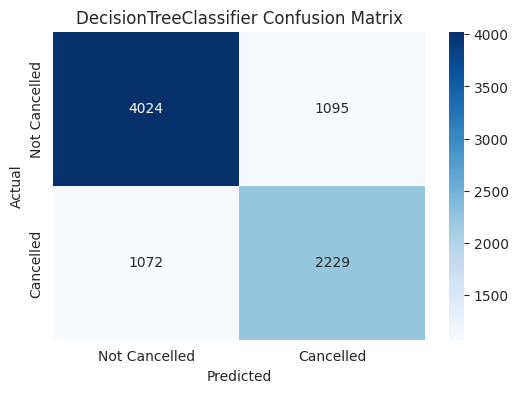

DecisionTreeClassifier Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5119
           1       0.67      0.68      0.67      3301

    accuracy                           0.74      8420
   macro avg       0.73      0.73      0.73      8420
weighted avg       0.74      0.74      0.74      8420

DecisionTreeClassifier Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78     20475
           1       0.67      0.66      0.66     13203

    accuracy                           0.74     33678
   macro avg       0.72      0.72      0.72     33678
weighted avg       0.74      0.74      0.74     33678



Training KNeighborsClassifier...
Stats for KNeighborsClassifier:


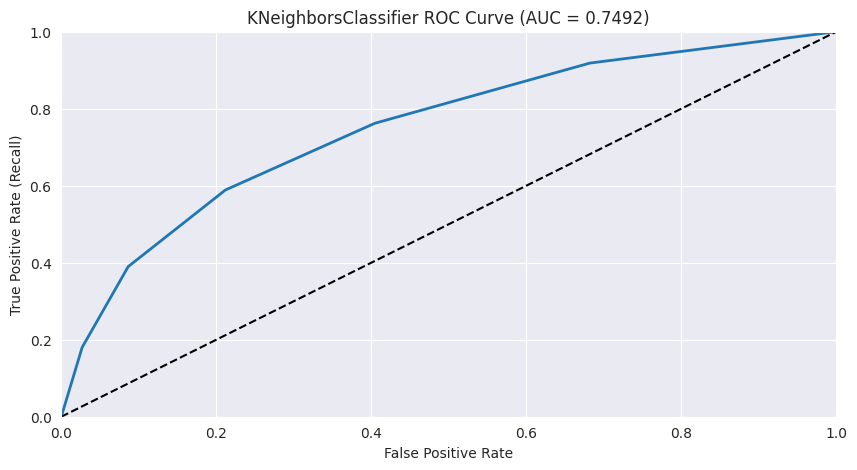

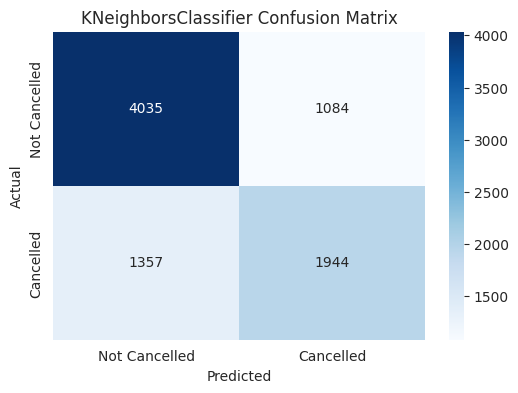

KNeighborsClassifier Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      5119
           1       0.64      0.59      0.61      3301

    accuracy                           0.71      8420
   macro avg       0.70      0.69      0.69      8420
weighted avg       0.71      0.71      0.71      8420

KNeighborsClassifier Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     20475
           1       0.65      0.60      0.62     13203

    accuracy                           0.72     33678
   macro avg       0.70      0.70      0.70     33678
weighted avg       0.71      0.72      0.72     33678





In [142]:
# let's iterate training for average classifiers
average_classifiers = {
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(max_iter=100, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=200,
                                                     max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier()
}

for name, model in average_classifiers.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"Stats for {name}:")
    get_stats(model, X_val, y_val, X_train, y_train)
    print("\n")

In [143]:
# let's iterate training for heavy classifiers
heavy_classifiers = {
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators=100, random_state=42),
    "KernelSVM": KernelSVM(kernel='rbf', probability=True, random_state=42)
}

# for name, model in heavy_classifiers.items():
#     print(f"Training {name}...")
#     model.fit(X_train_scaled, y_train)
#     print(f"Stats for {name}:")
#     get_stats(model, X_val_scaled, y_val, X_train_scaled, y_train)
#     print("\n")

In [144]:
# Hyperparameter Tuning for HistGradientBoostingClassifier
param_dist = {
    'max_iter': randint(50, 300),
    'max_depth': randint(3, 15),
    'min_samples_leaf': randint(1, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'l2_regularization': [0.0, 0.1, 0.5, 1.0, 5.0],
    'max_bins': randint(100, 255)
}

hgbc_model = HistGradientBoostingClassifier(random_state=42)
random_search = RandomizedSearchCV(hgbc_model, param_distributions=param_dist, cv=cv, n_iter=50, scoring='roc_auc', random_state=42, n_jobs=-1, return_train_score=False, verbose=0)
random_search.fit(X_train, y_train)

,estimator,HistGradientB...ndom_state=42)
,param_distributions,"{'l2_regularization': [0.0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_bins': <scipy.stats....x74da3dfc7170>, 'max_depth': <scipy.stats....x74da2fb944a0>, ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [145]:
# lets check best params
print("Best parameters found: ", random_search.best_params_)
best_hgbc_model = random_search.best_estimator_

Best parameters found:  {'l2_regularization': 5.0, 'learning_rate': 0.1, 'max_bins': 247, 'max_depth': 14, 'max_iter': 236, 'min_samples_leaf': 4}


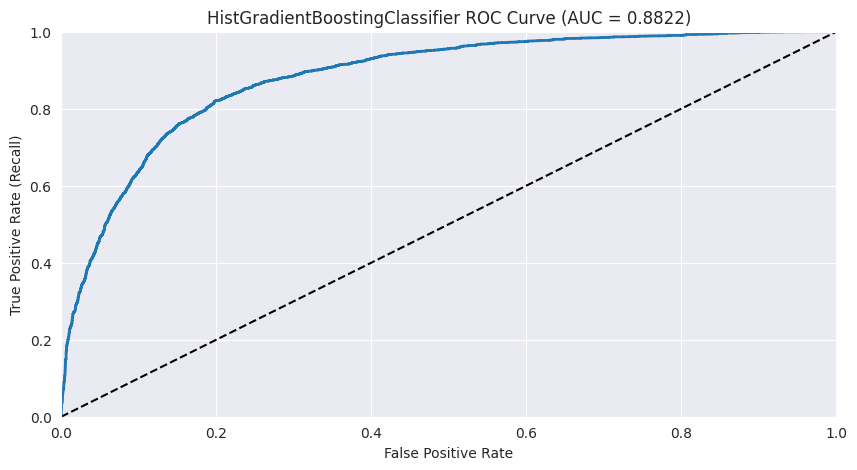

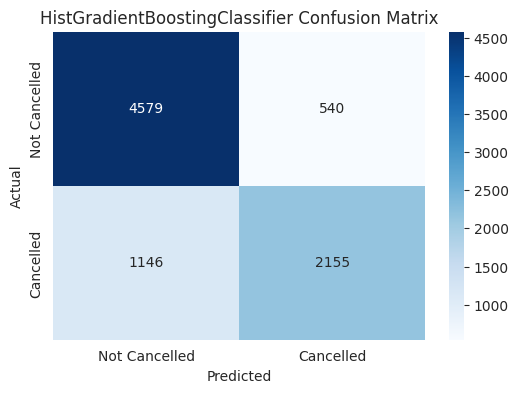

HistGradientBoostingClassifier Validation Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      5119
           1       0.80      0.65      0.72      3301

    accuracy                           0.80      8420
   macro avg       0.80      0.77      0.78      8420
weighted avg       0.80      0.80      0.80      8420

HistGradientBoostingClassifier Training Dataset Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.85     20475
           1       0.82      0.66      0.73     13203

    accuracy                           0.81     33678
   macro avg       0.81      0.78      0.79     33678
weighted avg       0.81      0.81      0.81     33678



In [146]:
# let's check stats for best_hgbc_model
get_stats(best_hgbc_model, X_val, y_val, X_train, y_train)

In [158]:
# let's train model on full train data
final_model = HistGradientBoostingClassifier(**random_search.best_params_, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # X = training features used for final_model.fit

final_model.fit(X_scaled, y)

,loss,'log_loss'
,learning_rate,0.1
,max_iter,236
,max_leaf_nodes,31
,max_depth,14
,min_samples_leaf,4
,l2_regularization,5.0
,max_features,1.0
,max_bins,247
,categorical_features,'from_dtype'
,monotonic_cst,None


In [159]:
scaled_test = scaler.transform(test_df)   # test_df must have same columns/order as X
predictions = final_model.predict(scaled_test)

this method returns probabilities for both classes, we need probabilities for class 1 only
example of predic_proba

|   | 0    | 1    |
|---|------|------|
| 0 | 0.85 | 0.15 |
| 1 | 0.30 | 0.70 |
| 2 | 0.60 | 0.40 |
| 3 | 0.10 | 0.90 |

so we need to take second column only and then convert it to binary predictions based on threshold 0.5

result should be like this
|   | booking_status |
|---|----------------|
| 0 | 0              |
| 1 | 1              |
| 2 | 0              |

In [160]:
# save according acceptence criteria
submission_df = pd.DataFrame({
    'id': test_ids,
    'booking_status': predictions
})
submission_df.to_csv('submission.csv', index=False)